# Steel temperature prediction

In order to optimize production costs, a steel mill has decided to reduce power consumption at the steel processing stage.

It is required to build a model that predicts the temperature of the steel. This will reduce electrical and maintenance costs.
The model should predict temperature with an error of less than 6.8 degrees (**MAE< 6.8**).

## Steel treatment process

To improve the quality of steel, this steel mill performs an out-of-furnace steel treatment.

Steel is treated in a ladle furnace with a capacity of about 100 tons. To ensure that the metal ladle can withstand high temperatures, it is lined with fire bricks on the inside. The molten steel is poured into the ladle and heated to the required temperature using graphite electrodes. They are installed in the ladle lid.

Sulphur is removed from the alloy (desulphurization), the chemical composition is adjusted by adding impurities, and samples are taken. Steel is alloyed — its composition is changed — by feeding pieces of alloy from a bulk hopper or wire through a special wire feeding machine.

Before adding alloying agents for the first time, the temperature of the steel is measured. It is also chemically analyzed. Then the temperature is raised for a few minutes, alloying materials are added and the alloy is purged with inert gas. The alloy is then stirred and measured again. This cycle is repeated until the target chemical composition and optimum melting temperature are achieved.

The molten steel is then sent for metal finishing or fed into a continuous casting machine. From there, the finished product comes out in the form of slabs.

## Data description

The data consists of files obtained from different sources:
- `data_arc_new.csv` — electrode data;
- `data_bulk_new.csv` — bulk material feed data (volume);
- `data_bulk_time_new.csv` — bulk material feeding data (time);
- `data_gas_new.csv` — data on gas purging of the alloy;
- `data_temp_new.csv` — temperature measurement results;
- `data_wire_new.csv` — data on wire materials (volume);
- `data_wire_time_new.csv` — data on wire materials (time).

In all files, the `key` column contains the batch number. There may be several lines in the files with the same `key` value: they correspond to different treatment iterations.

## Exploratory data analysis

Let's have a look at the data and identify the attributes that affect the temperature of steel.

In [134]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import catboost
import lightgbm as lgb

from sklearn.preprocessing import StandardScaler 
from sklearn.metrics import mean_absolute_error as mae
from sklearn.model_selection import train_test_split, cross_val_score, KFold, cross_val_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.utils._testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning

from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn.ensemble import RandomForestRegressor 
from sklearn.dummy import DummyRegressor
from catboost import CatBoostRegressor, Pool, cv

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense

In [2]:
try:
    data_arc = pd.read_csv('data_arc_new.csv')
    data_bulk = pd.read_csv('data_bulk_new.csv')
    data_bulk_time = pd.read_csv('data_bulk_time_new.csv')
    data_gas = pd.read_csv('data_gas_new.csv')
    data_temp = pd.read_csv('data_temp_new.csv')
    data_wire = pd.read_csv('data_wire_new.csv')
    data_wire_time = pd.read_csv('data_wire_time_new.csv')
except:
    data_arc = pd.read_csv('/datasets/data_arc_new.csv')
    data_bulk = pd.read_csv('/datasets/data_bulk_new.csv')
    data_bulk_time = pd.read_csv('/datasets/data_bulk_time_new.csv')
    data_gas = pd.read_csv('/datasets/data_gas_new.csv')
    data_temp = pd.read_csv('/datasets/data_temp_new.csv')
    data_wire = pd.read_csv('/datasets/data_wire_new.csv')
    data_wire_time = pd.read_csv('/datasets/data_wire_time_new.csv')

### Electrode data

In [3]:
data_arc.head()

,key,Start of arc heating,End of arc heating,Active power,Reactive power
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691


In [4]:
data_arc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Start of arc heating  14876 non-null  object 
 2   End of arc heating    14876 non-null  object 
 3   Active power          14876 non-null  float64
 4   Reactive power        14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


There are no missing values, dates are represented by strings.
Let's look at the dataframe statistics.

In [5]:
data_arc.describe()

,key,Active power,Reactive power
count,14876.000000,14876.000000,14876.000000
mean,1615.220422,0.662752,0.438986
std,934.571502,0.258885,5.873485
min,1.000000,0.223120,-715.479924
25%,806.000000,0.467115,0.337175
50%,1617.000000,0.599587,0.441639
75%,2429.000000,0.830070,0.608201
max,3241.000000,1.463773,1.270284


There are negative values in the reactive power numbers. This may be the reason why the dispersion of this parameter is higher.

The period for which data are available.

In [6]:
print('First date:', data_arc['Start of arc heating'].min())
print('Last date:', data_arc['End of arc heating'].max())

First date: 2019-05-03 11:02:14
Last date: 2019-09-06 17:26:15


Apparently, the May through September 2019 interval is covered.

Let's see how many arc heatings are averaged per ladle.

In [7]:
data_arc['key'].value_counts()

2108    16
1689    15
1513    15
2567    14
46      13
        ..
977      1
247      1
2582     1
248      1
530      1
Name: key, Length: 3214, dtype: int64

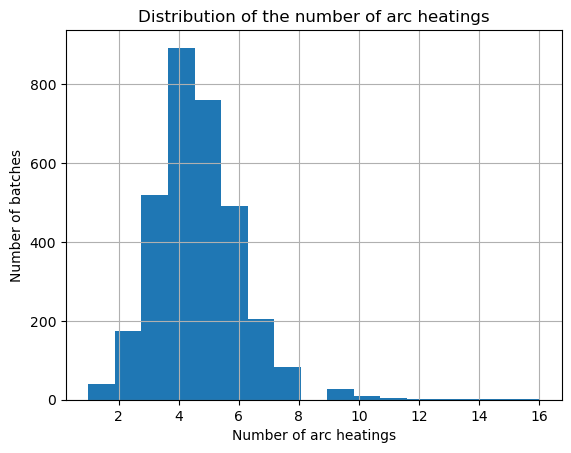

In [8]:
data_arc['key'].value_counts().hist(bins=17)
plt.title('Distribution of the number of arc heatings')
plt.xlabel('Number of arc heatings')
plt.ylabel('Number of batches')
plt.show()

On average about 4 times, although there have been some that have been heated 16 times.

Let's estimate the number of negative reactive power values.

In [9]:
data_arc[data_arc['Reactive power'] < 0]

,key,Start of arc heating,End of arc heating,Active power,Reactive power
9780,2116,2019-07-28 02:22:08,2019-07-28 02:23:57,0.705344,-715.479924


One single line. Let's look at all the data on this ladle.

In [10]:
data_arc.query('key == 2116')

,key,Start of arc heating,End of arc heating,Active power,Reactive power
9778,2116,2019-07-28 02:07:12,2019-07-28 02:09:14,0.787549,0.693881
9779,2116,2019-07-28 02:13:10,2019-07-28 02:15:25,0.580263,0.411498
9780,2116,2019-07-28 02:22:08,2019-07-28 02:23:57,0.705344,-715.479924
9781,2116,2019-07-28 02:29:11,2019-07-28 02:30:18,0.563641,0.408513


Let's get rid of the entire series at the preprocessing stage. Even one abnormal value casts doubt on the rest of the measurements.

In [11]:
data_arc_pos = data_arc.drop(data_arc[data_arc['Reactive power'] < 0].index)
data_arc_pos.head()

,key,Start of arc heating,End of arc heating,Active power,Reactive power
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691


Let's estimate the correlation between active and reactive powers:

In [12]:
data_arc['Active power'].corr(data_arc['Reactive power'])

0.031164148606199774

Если без выброса:

In [13]:
data_arc_pos['Active power'].corr(data_arc_pos['Reactive power'])

0.9663734456187298

Это больше похоже на правду. Убедимся на графике:

/home/leonid/anaconda3/envs/practicum/lib/python3.9/site-packages/pandas/plotting/_matplotlib/core.py:1041: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


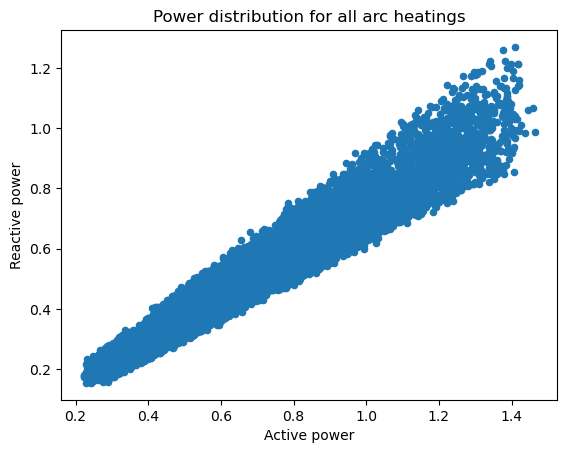

In [14]:
data_arc_pos.plot(x='Active power', y='Reactive power', kind='scatter')
plt.title('Power distribution for all arc heatings')
plt.show()

Here is the coefficient.

In [15]:
model = LinearRegression()
model.fit(data_arc_pos['Active power'].values.reshape(-1, 1), 
          data_arc_pos['Reactive power'].values.reshape(-1, 1))
model.coef_

array([[0.73762827]])

It may be better to take only one of these two features for training.

For each ladle, we will also calculate the total heating time and the total time from the start of heating to the end.

In [16]:
data_arc['Heating time'] = (pd.to_datetime(data_arc['End of arc heating']) - 
                             pd.to_datetime(data_arc['Start of arc heating'])).dt.total_seconds()
data_arc.head()

,key,Start of arc heating,End of arc heating,Active power,Reactive power,Heating time
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253,228.0
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438,185.0
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460,172.0
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979,365.0
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691,148.0


In [17]:
data_arc_stat = pd.pivot_table(data_arc, values='Heating time', index='key', aggfunc='sum')
data_arc_stat.head()

,Heating time
key,
1,1098.0
2,811.0
3,655.0
4,741.0
5,869.0


Note that there are gaps in the key numbers.

In [18]:
for i in range(len(data_arc_stat.index)):
    if i not in data_arc_stat.index:
        print(i)

0
41
42
195
279
355
382
506
529
540
607
683
710
766
1133
1300
1437
2031
2103
2278
2356
2373
2446
2469
2491
2683
3200
3207


Although it's hardly significant.

In [19]:
data_arc_stat['Treatment time'] = (pd.to_datetime(pd.pivot_table(
    data_arc, values='End of arc heating', index='key', aggfunc='max')['End of arc heating']) - 
                                    pd.to_datetime(pd.pivot_table(
    data_arc, values='Start of arc heating', index='key', aggfunc='min')['Start of arc heating'])
                                   ).dt.total_seconds()
data_arc_stat.head()

,Heating time,Treatment time
key,,
1,1098.0,1583.0
2,811.0,1144.0
3,655.0,1525.0
4,741.0,1093.0
5,869.0,1362.0


We can also calculate work from the power and time. This physical quantity can possibly have a more direct link to the temperature.

In [20]:
data_arc['Total power'] = (data_arc['Active power']**2 + data_arc['Reactive power']**2)**0.5
data_arc['Work'] = data_arc['Total power'] * data_arc['Heating time']
data_arc.head()

,key,Start of arc heating,End of arc heating,Active power,Reactive power,Heating time,Total power,Work
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253,228.0,0.371123,84.616003
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438,185.0,0.902319,166.928978
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460,172.0,0.722536,124.276277
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979,365.0,0.642824,234.630603
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691,148.0,1.079934,159.830252


Seems like work reflects the consumed energy better. Let's take it instead of active power and heating time.

The anomaly in reactive power has not gone anywhere and this batch will have to be weeded out before getting the samples.

Besides that, these features can be taken for training after preprocessing the data.

**Summary**
- The data covers the period from May through September 2019.
- Most batches were heated between 2 and 8 times.
- The active and reactive power data correlate with each other. It makes sense to keep only one of them.
- There are 27 gaps in the batch numbering. It's not important for training.
- There is one anomaly in the reactive power data. The batch with this anomaly will be excluded at the preprocessing stage.
- Two new features have been created: total batch heating time and total batch treatment time. The latter includes the former, but is more reflective of the effect of metal cooling over time, so it will be taken for the training.
- Instead of power and total batch heating time, a feature of total work was calculated and will be taken for training.

### Bulk material feed data (volume)

In [21]:
data_bulk.head()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0


Apparently not all types of bulk solids are fed at one time.  
I assume the units of measure are liters.

In [22]:
data_bulk.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


A lot of missing values are present. In our case they can be replaced by zeros without affecting the model training.

In [23]:
data_bulk[~data_bulk['Bulk 8'].isna()]

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
1725,1786,NaN,NaN,123.0,NaN,NaN,NaN,NaN,49.0,147.0,NaN,NaN,NaN,NaN,NaN,NaN


For some bulk materials the data is clearly insufficient.
For training and testing, we will take those that are more than 500. It will be necessary to warn the customer that the rest are not included in the calculation.

In [24]:
data_bulk.describe().round()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
count,3129.0,252.0,22.0,1298.0,1014.0,77.0,576.0,25.0,1.0,19.0,176.0,177.0,2450.0,18.0,2806.0,2248.0
mean,1624.0,39.0,253.0,114.0,104.0,107.0,119.0,306.0,49.0,76.0,83.0,77.0,260.0,181.0,170.0,161.0
std,933.0,18.0,21.0,75.0,48.0,82.0,72.0,191.0,NaN,22.0,26.0,60.0,121.0,46.0,66.0,52.0
min,1.0,10.0,228.0,6.0,12.0,11.0,17.0,47.0,49.0,63.0,24.0,8.0,53.0,151.0,16.0,1.0
25%,816.0,27.0,242.0,58.0,72.0,70.0,70.0,155.0,49.0,66.0,64.0,25.0,204.0,153.0,119.0,105.0
50%,1622.0,31.0,252.0,98.0,102.0,86.0,100.0,298.0,49.0,68.0,86.0,64.0,208.0,156.0,151.0,160.0
75%,2431.0,46.0,258.0,152.0,133.0,132.0,157.0,406.0,49.0,70.0,102.0,106.0,316.0,204.0,206.0,205.0
max,3241.0,185.0,325.0,454.0,281.0,603.0,503.0,772.0,49.0,147.0,159.0,313.0,1849.0,305.0,636.0,405.0


The mean values do not differ very much. Although 1849 liters are out of the general picture.

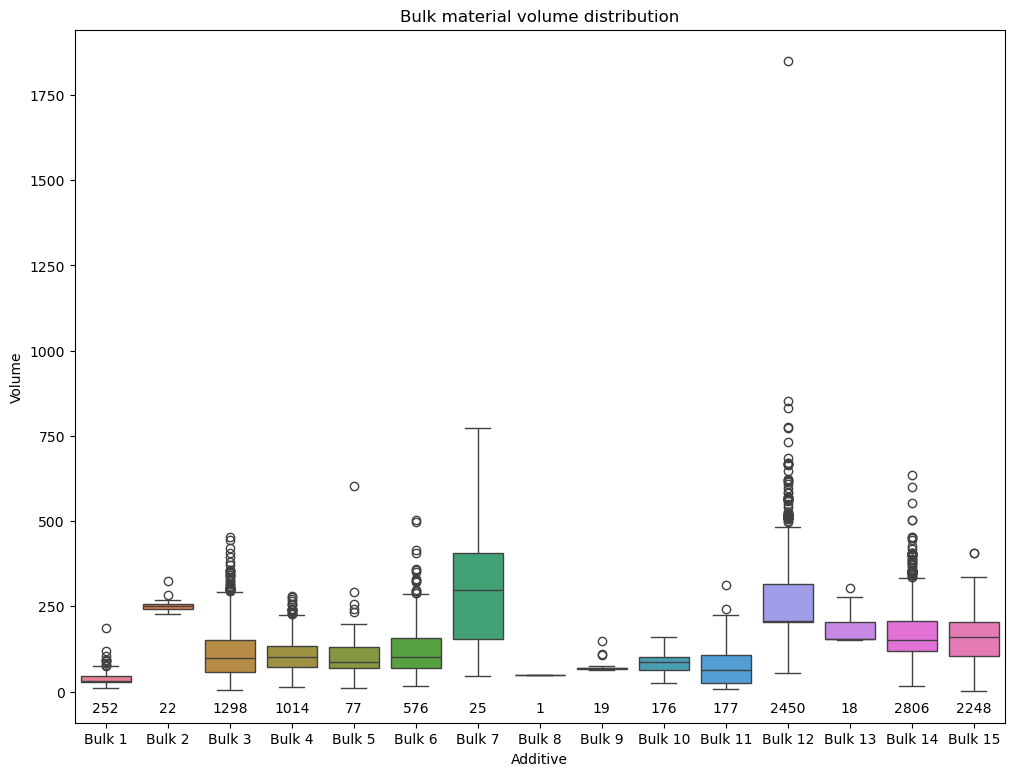

In [25]:
fig, ax = plt.subplots(figsize=(12, 9))
fig = sns.boxplot(data=data_bulk.drop('key', axis=1))
plt.title('Bulk material volume distribution')
plt.xlabel('Additive')
plt.ylabel('Volume')
for tick in range(len(fig.get_xticklabels())):
    fig.text(tick, -60, str(data_bulk['Bulk ' + str(tick+1)].notna().sum()), horizontalalignment='center')
plt.show()

Without the outlier:

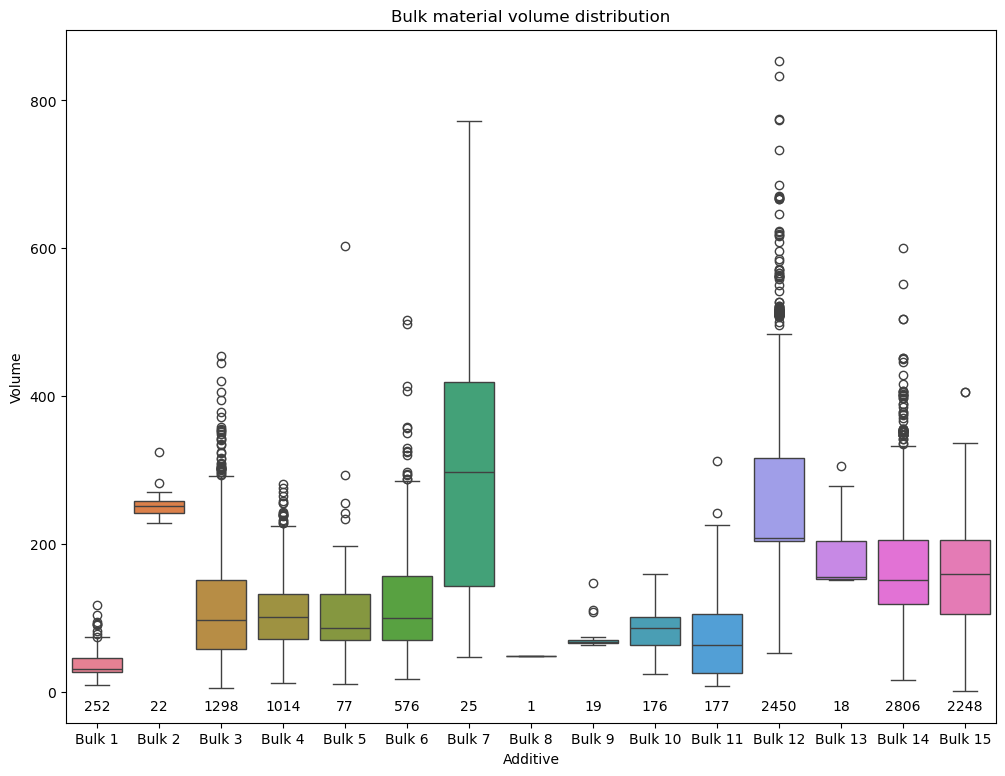

In [26]:
fig, ax = plt.subplots(figsize=(12, 9))
fig = (sns.boxplot(data=data_bulk
                  .query('`Bulk 12` < 1849 | `Bulk 12`.isnull()', engine='python')
                  .drop(['key'], axis=1)))
plt.title('Bulk material volume distribution')
plt.xlabel('Additive')
plt.ylabel('Volume')
for tick in range(len(fig.get_xticklabels())):
    fig.text(tick, -25, str(data_bulk['Bulk ' + str(tick+1)].notna().sum()), horizontalalignment='center')
plt.show()

Those that have been added to more than 500 batches are distributed quite standardly. Although the number of outliers is different everywhere.
The only thing that catches my eye is the proximity of the first and second quartiles for Bulk 12. Apparently, about 200 liters are added quite often.

**Summary**
- The data reflect the addition of 15 types of bulk materials.
- Gaps in the data can be replaced with zeros.
- Additives are used unevenly. Some have been used only a few times.
- For training and testing, we will take those that have been added more than 500 times. With scaling.
- Let's remove outliers in the training sample.

### Bulk material feed data (time)

In [27]:
data_bulk_time.head()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,2019-05-03 11:28:48,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:24:31,NaN,2019-05-03 11:14:50,2019-05-03 11:10:43
1,2,NaN,NaN,NaN,2019-05-03 11:36:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:53:30,NaN,2019-05-03 11:48:37,2019-05-03 11:44:39
2,3,NaN,NaN,NaN,2019-05-03 12:32:39,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:27:13,NaN,2019-05-03 12:21:01,2019-05-03 12:16:16
3,4,NaN,NaN,NaN,2019-05-03 12:43:22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:58:00,NaN,2019-05-03 12:51:11,2019-05-03 12:46:36
4,5,NaN,NaN,NaN,2019-05-03 13:30:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:30:47,NaN,2019-05-03 13:34:12,2019-05-03 13:30:47


In [28]:
data_bulk_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   Bulk 1   252 non-null    object
 2   Bulk 2   22 non-null     object
 3   Bulk 3   1298 non-null   object
 4   Bulk 4   1014 non-null   object
 5   Bulk 5   77 non-null     object
 6   Bulk 6   576 non-null    object
 7   Bulk 7   25 non-null     object
 8   Bulk 8   1 non-null      object
 9   Bulk 9   19 non-null     object
 10  Bulk 10  176 non-null    object
 11  Bulk 11  177 non-null    object
 12  Bulk 12  2450 non-null   object
 13  Bulk 13  18 non-null     object
 14  Bulk 14  2806 non-null   object
 15  Bulk 15  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB


Apparently, there is a full match with the volume data.  
Let's look at the periods when different types of bulk materials were added. And count the number of additions by week.

In [29]:
data_bulk_time_weeks = data_bulk_time.copy()
data_bulk_time_weeks = pd.DataFrame(data_bulk_time_weeks['key']).join(
    pd.to_datetime(data_bulk_time_weeks
                   .drop('key', axis=1)
                   .stack()).astype('datetime64[W]').unstack())
data_bulk_time_weeks.head()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaT,NaT,NaT,2019-05-02,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-02,NaT,2019-05-02,2019-05-02
1,2,NaT,NaT,NaT,2019-05-02,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-02,NaT,2019-05-02,2019-05-02
2,3,NaT,NaT,NaT,2019-05-02,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-02,NaT,2019-05-02,2019-05-02
3,4,NaT,NaT,NaT,2019-05-02,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-02,NaT,2019-05-02,2019-05-02
4,5,NaT,NaT,NaT,2019-05-02,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-02,NaT,2019-05-02,2019-05-02


Посчитаем количество партий для каждой недели.

In [30]:
data_bulk_time_stat = data_bulk_time_weeks.drop('key', axis=1).apply(pd.value_counts)
data_bulk_time_stat

,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
2019-05-02,18,6.0,35,38,6.0,36,1.0,NaN,NaN,8.0,6,99,1.0,110,93
2019-05-09,19,NaN,69,49,8.0,38,1.0,NaN,10.0,2.0,6,138,2.0,159,116
2019-05-16,20,NaN,46,85,2.0,16,NaN,NaN,NaN,22.0,5,157,1.0,168,152
2019-05-23,7,NaN,44,80,NaN,29,NaN,NaN,NaN,7.0,6,142,1.0,152,126
2019-05-30,8,NaN,90,47,NaN,21,NaN,NaN,NaN,11.0,4,122,1.0,154,100
2019-06-06,22,NaN,100,39,1.0,50,NaN,NaN,NaN,4.0,14,142,1.0,167,130
2019-06-13,17,NaN,83,84,3.0,22,1.0,NaN,NaN,3.0,8,146,NaN,169,128
2019-06-20,19,NaN,100,66,NaN,23,1.0,NaN,NaN,11.0,3,163,1.0,168,156
2019-06-27,15,NaN,73,61,NaN,31,NaN,NaN,NaN,15.0,4,141,2.0,159,131
2019-07-04,22,NaN,83,52,16.0,26,NaN,1.0,1.0,14.0,6,143,1.0,176,128


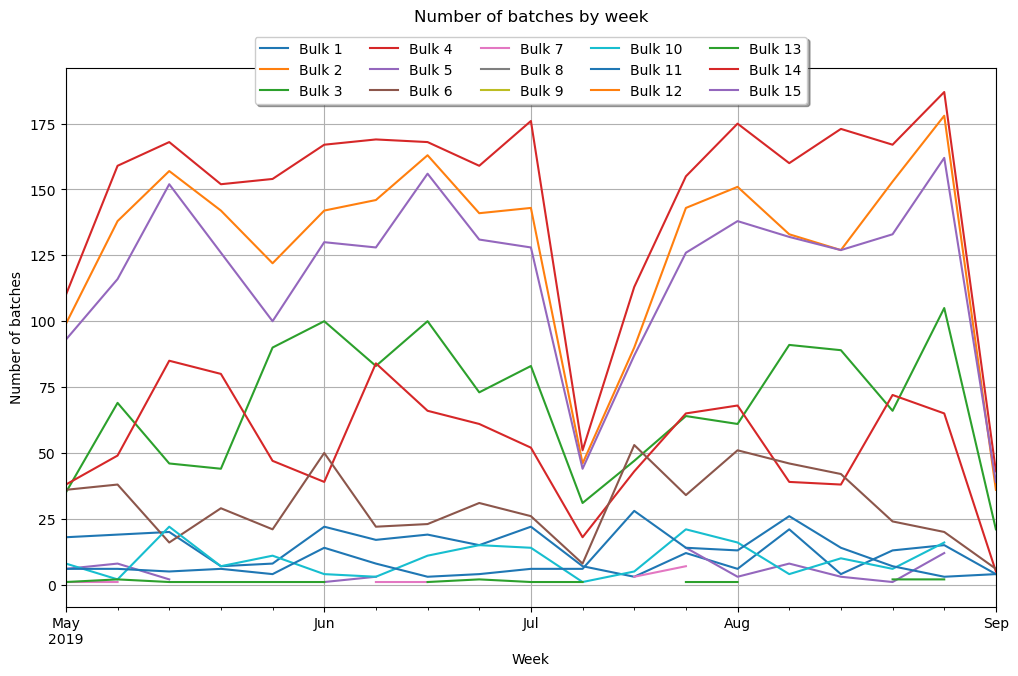

In [31]:
data_bulk_time_stat.plot(grid=True, figsize=(12, 7))
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.07), ncol=5, shadow=True)
plt.title('Number of batches by week', y=1.07)
plt.ylabel('Number of batches')
plt.xlabel('Week')
plt.show()

The correlation is clearly traceable. The summer dip may be related to vacations.

The exact feeding time of the bulk solids probably has no effect on the final temperature. This data will not be used for training.

**Summary**
- Additives were used uniformly.
- These data will not be used in training.

### Alloy gas purge data

In [32]:
data_gas.head()

,key,Gas 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692


In [33]:
data_gas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Gas 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


Пропусков нет.

In [34]:
data_gas['key'].duplicated().sum()

0

There are batches for which there is no electrode data. They'll be weeded out later with the `.join(how='inner')` method.

In [35]:
data_gas.describe()

,key,Gas 1
count,3239.000000,3239.000000
mean,1621.861377,11.002062
std,935.386334,6.220327
min,1.000000,0.008399
25%,812.500000,7.043089
50%,1622.000000,9.836267
75%,2431.500000,13.769915
max,3241.000000,77.995040


Let's estimate the distribution of this parameter.

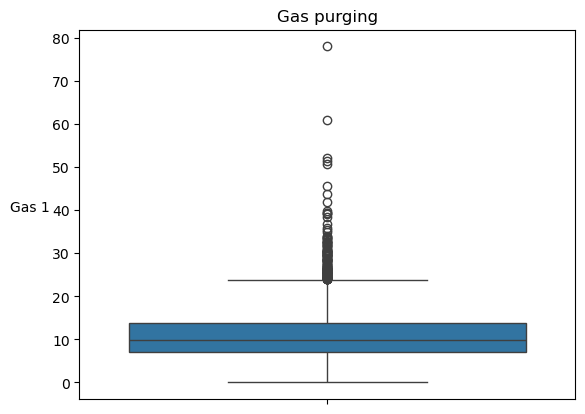

In [36]:
fig, ax = plt.subplots()
fig = sns.boxplot(data=data_gas['Gas 1'])
ax.yaxis.set_label_coords(-0.1, 0.0)
plt.title('Gas purging')
plt.ylabel('Gas 1', rotation=0)
plt.show()

Outliers are to be included in the test sample, but not taken in the training sample.

**Summary**
- It is not clear what Gas 1 is measured in.
- There are outliers that are not anomalies. They should be kept in the test sample, but excluded from the training sample.

### Temperature measurement results

In [37]:
data_temp.head()

,key,Time of measurement,Temperature
0,1,2019-05-03 11:02:04,1571.0
1,1,2019-05-03 11:07:18,1604.0
2,1,2019-05-03 11:11:34,1618.0
3,1,2019-05-03 11:18:04,1601.0
4,1,2019-05-03 11:25:59,1606.0


Now to the missing values.

In [38]:
data_temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18092 entries, 0 to 18091
Data columns (total 3 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   key                  18092 non-null  int64  
 1   Time of measurement  18092 non-null  object 
 2   Temperature          14665 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 424.2+ KB


Temperature is a key parameter. Batches for which the temperature is unknown should be excluded from analysis.

Let's build a histogram of the number of batches by the number of measurements.

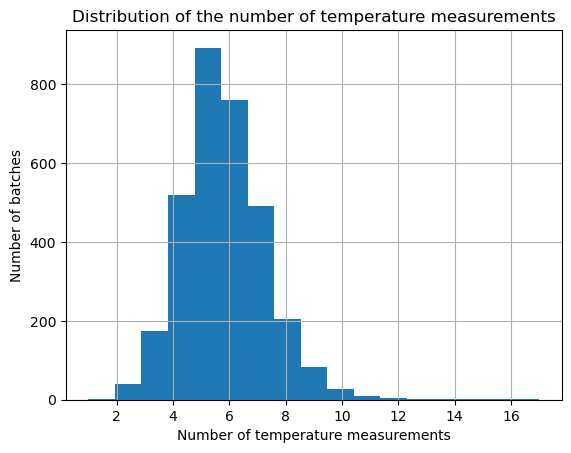

In [39]:
data_temp['key'].value_counts().hist(bins=17)
plt.title('Distribution of the number of temperature measurements')
plt.ylabel('Number of batches')
plt.xlabel('Number of temperature measurements')
plt.show()

No abnormal values are observed. Although the few for which there is only one dimension will need to be removed because the prediction coincides with the training feature.

Here is the boxplot of the temperature itself.

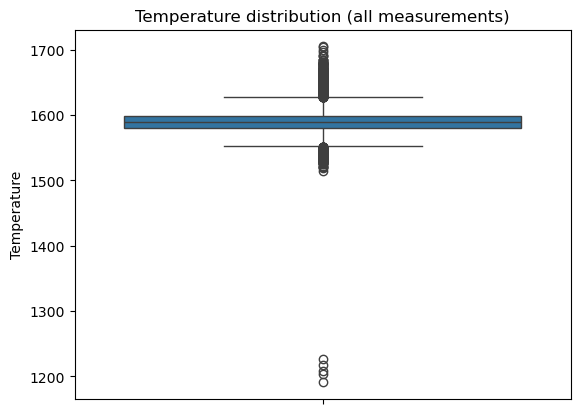

In [40]:
sns.boxplot(data=data_temp['Temperature'])
plt.title('Temperature distribution (all measurements)')
plt.ylabel('Temperature')
plt.show()

The melting point of alloy steel starts somewhere around 1400 °C, so values around 1200 degrees are abnormal. The batches with them should be discarded.

In [41]:
data_temp['Temperature'].describe()

count    14665.000000
mean      1590.722741
std         20.394381
min       1191.000000
25%       1580.000000
50%       1590.000000
75%       1599.000000
max       1705.000000
Name: Temperature, dtype: float64

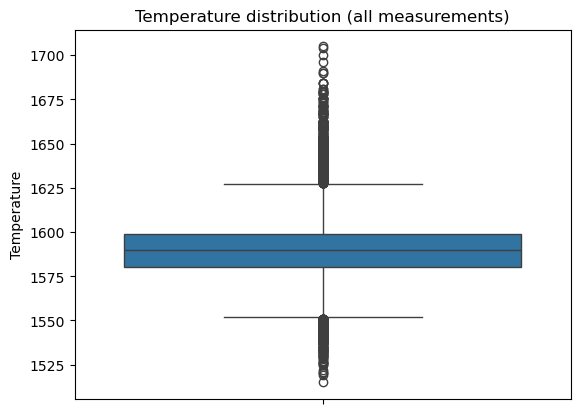

In [42]:
sns.boxplot(data=data_temp.query('Temperature > 1400')['Temperature'])
plt.title('Temperature distribution (all measurements)')
plt.ylabel('Temperature')
plt.show()

The rest of the numbers look plausible. I think even outliers should not be excluded from the test sample.

Let's also look at the average temperature of batch.

In [43]:
data_temp_stat = data_temp.query('Temperature > 1400').groupby('key')['Temperature'].agg('mean')
data_temp_stat.head()

key
1    1602.166667
2    1590.600000
3    1598.166667
4    1616.800000
5    1589.000000
Name: Temperature, dtype: float64

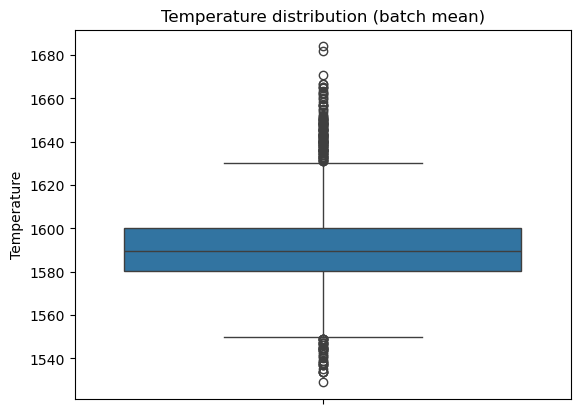

In [44]:
sns.boxplot(data=data_temp_stat.reset_index()['Temperature'])
plt.title('Temperature distribution (batch mean)')
plt.ylabel('Temperature')
plt.show()

In [45]:
len(data_temp['key'].unique())

3216

**Summary**
- On average temperature is measured about 5 times.
- There are missing values, the batches with which must be dropped.
- There are abnormally low temperatures with which we should do the same.
- The rest of the temperature values can be taken for training and testing.

### Wire materials data (volume)

In [46]:
data_wire.head()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [47]:
data_wire.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


There are a lot of gaps again. Let's fill them in with zeros.

In [48]:
data_wire.describe()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
count,3081.000000,3055.000000,1079.000000,63.000000,14.000000,1.000,73.000000,11.000000,19.000000,29.000000
mean,1623.426485,100.895853,50.577323,189.482681,57.442841,15.132,48.016974,10.039007,53.625193,34.155752
std,932.996726,42.012518,39.320216,99.513444,28.824667,NaN,33.919845,8.610584,16.881728,19.931616
min,1.000000,1.918800,0.030160,0.144144,24.148801,15.132,0.034320,0.234208,45.076721,4.622800
25%,823.000000,72.115684,20.193680,95.135044,40.807002,15.132,25.053600,6.762756,46.094879,22.058401
50%,1619.000000,100.158234,40.142956,235.194977,45.234282,15.132,42.076324,9.017009,46.279999,30.066399
75%,2434.000000,126.060483,70.227558,276.252014,76.124619,15.132,64.212723,11.886057,48.089603,43.862003
max,3241.000000,330.314424,282.780152,385.008668,113.231044,15.132,180.454575,32.847674,102.762401,90.053604


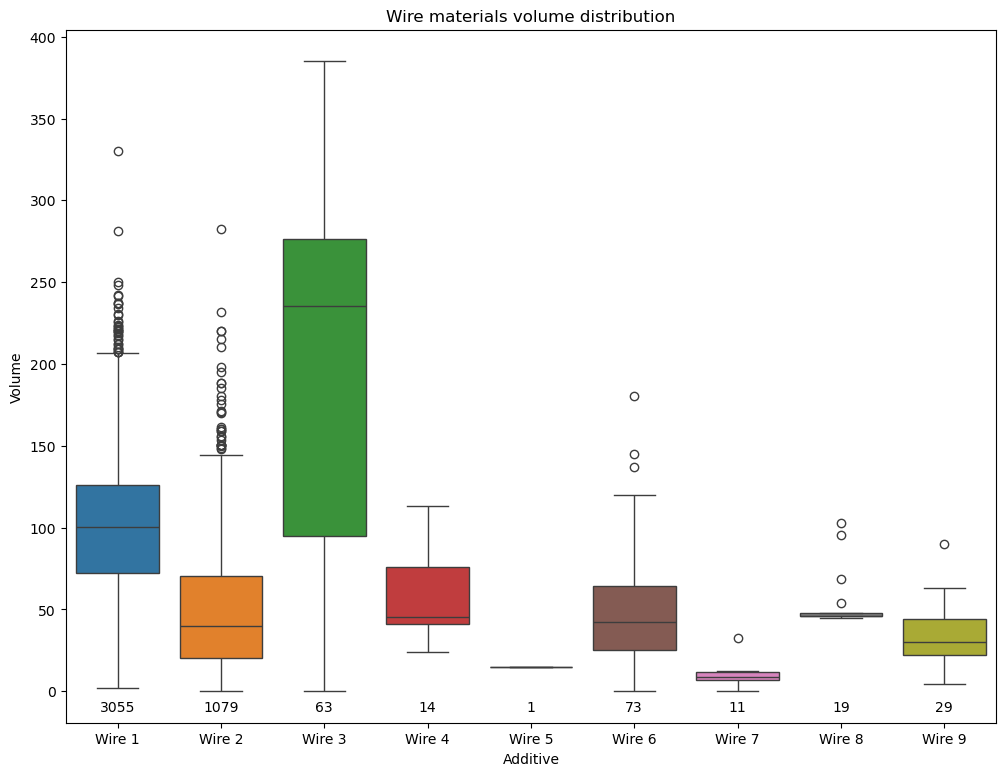

In [49]:
fig, ax = plt.subplots(figsize=(12, 9))
fig = sns.boxplot(data=data_wire.drop(['key'], axis=1))
plt.title('Wire materials volume distribution')
plt.xlabel('Additive')
plt.ylabel('Volume')
for tick in range(len(fig.get_xticklabels())):
    fig.text(tick, -12, str(data_wire['Wire ' + str(tick+1)].notna().sum()), horizontalalignment='center')
plt.show()

Let's take the first two. There's plenty of data on them.  
There are suspiciously low values, but I don't think they are anomalies.

**Summary**
- There are many gaps in the data that need to be filled in with zeros.
- For the two wires alone, there is enough data. Let's take them for training, with scaling.
- No abnormal volume values are observed.

### Wire materials data (time)

In [50]:
data_wire_time.head()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:06:19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:36:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:11:46,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2019-05-03 12:43:22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2019-05-03 13:20:44,2019-05-03 13:15:34,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [51]:
data_wire_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   Wire 1  3055 non-null   object
 2   Wire 2  1079 non-null   object
 3   Wire 3  63 non-null     object
 4   Wire 4  14 non-null     object
 5   Wire 5  1 non-null      object
 6   Wire 6  73 non-null     object
 7   Wire 7  11 non-null     object
 8   Wire 8  19 non-null     object
 9   Wire 9  29 non-null     object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB


Also a full match. Let's look at the number of additives by week.

In [52]:
data_wire_time_weeks = data_wire_time.copy()
data_wire_time_weeks = pd.DataFrame(data_wire_time_weeks['key']).join(
    pd.to_datetime(data_wire_time_weeks
                   .drop('key', axis=1)
                   .stack()).astype('datetime64[W]').unstack())
data_wire_time_weeks.head()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-02,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
1,2,2019-05-02,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
2,3,2019-05-02,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
3,4,2019-05-02,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
4,5,2019-05-02,2019-05-02,NaT,NaT,NaT,NaT,NaT,NaT,NaT


In [53]:
data_wire_time_stat = data_wire_time_weeks.drop('key', axis=1).apply(pd.value_counts)
data_wire_time_stat

,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
2019-05-02,117,44,10.0,3.0,NaN,21.0,NaN,NaN,1.0
2019-05-09,176,75,NaN,NaN,NaN,4.0,NaN,10.0,NaN
2019-05-16,173,56,4.0,NaN,NaN,NaN,NaN,NaN,NaN
2019-05-23,168,45,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-05-30,157,52,1.0,NaN,NaN,NaN,NaN,NaN,5.0
2019-06-06,191,72,4.0,NaN,NaN,NaN,NaN,NaN,9.0
2019-06-13,192,37,3.0,NaN,NaN,NaN,NaN,NaN,NaN
2019-06-20,190,50,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-06-27,187,92,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-07-04,188,69,3.0,NaN,NaN,NaN,NaN,1.0,5.0


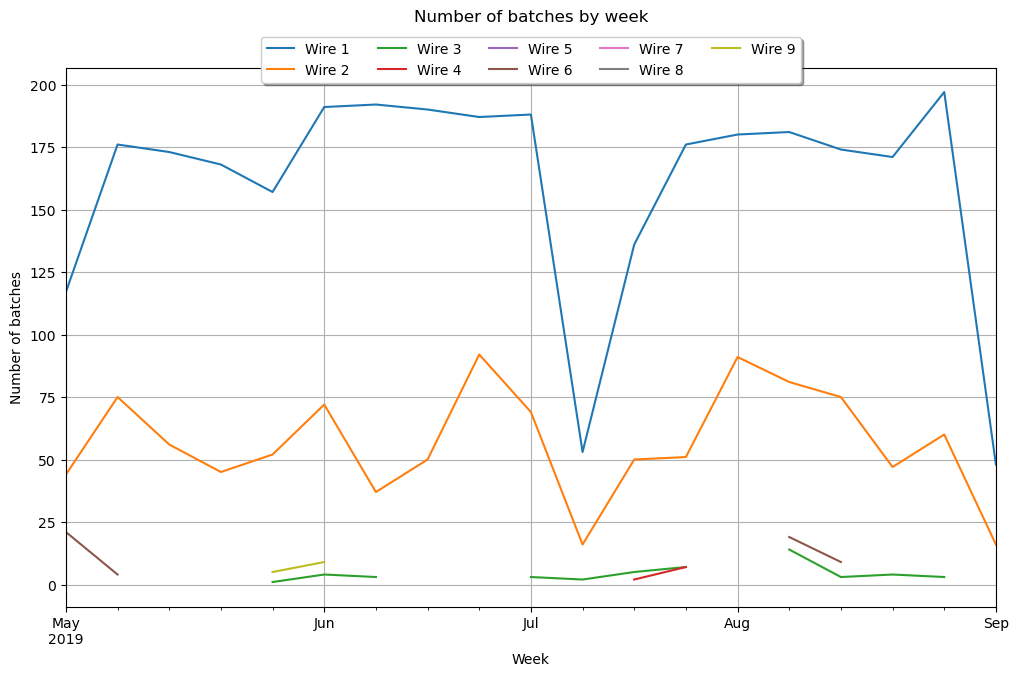

In [54]:
data_wire_time_stat.plot(grid=True, figsize=(12, 7))
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.07), ncol=5, shadow=True)
plt.title('Number of batches by week', y=1.07)
plt.ylabel('Number of batches')
plt.xlabel('Week')
plt.show()

The picture is similar. Even wire materials with a small number of batches were used periodically. For the two main ones the time series are similar.

**Summary**
- Two common types of wire materials were used throughout the whole time period.
- We will not use these data.

## Plan

1. Load data from all datasets except for two datasets about the time of feeding additives.
2. Process the gaps as follows:
    - Fill with zeros for bulk and wire materials volume data
    - Discard batches with gaps for temperature values
3. Process the anomalies as follows:
    - Remove the batch with a negative reactive power value for the electrode data.
    - Remove the batches with temperature values around 1200 degrees.
4. Take the following attributes for training and testing:
    - Work calculated from active and reactive power multiplied by heating time
    - Total treament time in seconds (heating time + breaks)
    - Volume of added bulk materials 3, 4, 6, 12, 14 and 15
    - Volume of wire materials 1 and 2
    - Initial temperature of the alloy
    - Gas purge values (they reflect cooling)
5. Take the last temperature for each batch as the target feature
6. Carry out an exploratory analysis of the resulting features, see the correlation
7. Split into training and test datasets
8. Remove from the training dataset:
    - Outliers in bulk and wire volume values
    - Outliers in gas purge values
9. Perform data scaling (trained on the training sample only).
10. Train and cross-validate the following models:
    - Linear Regression
    - Elastic Net
    - Random Forest
    - LightGBM
    - CatBoost
11. Compare MAE of the best of them with MAE of models predicting always mean and median temperature
12. Analyze the importance of the features of the tested model
13. Test the model
14. Write a report

## Data preprocessing

In [55]:
try:
    data_arc = pd.read_csv('data_arc_new.csv')
    data_bulk = pd.read_csv('data_bulk_new.csv')
    data_gas = pd.read_csv('data_gas_new.csv')
    data_temp = pd.read_csv('data_temp_new.csv')
    data_wire = pd.read_csv('data_wire_new.csv')
except:
    data_arc = pd.read_csv('/datasets/data_arc_new.csv')
    data_bulk = pd.read_csv('/datasets/data_bulk_new.csv')
    data_gas = pd.read_csv('/datasets/data_gas_new.csv')
    data_temp = pd.read_csv('/datasets/data_temp_new.csv')
    data_wire = pd.read_csv('/datasets/data_wire_new.csv')

### Data Types

Let's convert strings to datetime.

In [56]:
data_arc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Start of arc heating  14876 non-null  object 
 2   End of arc heating    14876 non-null  object 
 3   Active power          14876 non-null  float64
 4   Reactive power        14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


In [57]:
data_arc.loc[:, ['Start of arc heating', 'End of arc heating']] = (
    data_arc.loc[:, ['Start of arc heating', 'End of arc heating']].apply(pd.to_datetime))

In [58]:
data_arc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   key                   14876 non-null  int64         
 1   Start of arc heating  14876 non-null  datetime64[ns]
 2   End of arc heating    14876 non-null  datetime64[ns]
 3   Active power          14876 non-null  float64       
 4   Reactive power        14876 non-null  float64       
dtypes: datetime64[ns](2), float64(2), int64(1)
memory usage: 581.2 KB


In [59]:
data_temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18092 entries, 0 to 18091
Data columns (total 3 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   key                  18092 non-null  int64  
 1   Time of measurement  18092 non-null  object 
 2   Temperature          14665 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 424.2+ KB


In [60]:
data_temp['Time of measurement'] = pd.to_datetime(data_temp['Time of measurement'], format='%Y-%m-%d %H:%M:%S')

In [61]:
data_temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18092 entries, 0 to 18091
Data columns (total 3 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   key                  18092 non-null  int64         
 1   Time of measurement  18092 non-null  datetime64[ns]
 2   Temperature          14665 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 424.2 KB


### Missing values

In [62]:
data_bulk.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


In [63]:
data_bulk.fillna(0, inplace=True)
data_wire.fillna(0, inplace=True)

In [64]:
data_bulk.head()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,0.0,0.0,0.0,43.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,150.0,154.0
1,2,0.0,0.0,0.0,73.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,149.0,154.0
2,3,0.0,0.0,0.0,34.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,205.0,0.0,152.0,153.0
3,4,0.0,0.0,0.0,81.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,207.0,0.0,153.0,154.0
4,5,0.0,0.0,0.0,78.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,203.0,0.0,151.0,152.0


In [65]:
data_wire.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3081 non-null   float64
 2   Wire 2  3081 non-null   float64
 3   Wire 3  3081 non-null   float64
 4   Wire 4  3081 non-null   float64
 5   Wire 5  3081 non-null   float64
 6   Wire 6  3081 non-null   float64
 7   Wire 7  3081 non-null   float64
 8   Wire 8  3081 non-null   float64
 9   Wire 9  3081 non-null   float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


In [66]:
data_temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18092 entries, 0 to 18091
Data columns (total 3 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   key                  18092 non-null  int64         
 1   Time of measurement  18092 non-null  datetime64[ns]
 2   Temperature          14665 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 424.2 KB


In [67]:
keys_with_nan = data_temp.loc[data_temp['Temperature'].isna(), 'key'].drop_duplicates()
keys_with_nan

13927    2500
13932    2501
13939    2502
13944    2503
13949    2504
         ... 
18062    3237
18068    3238
18072    3239
18081    3240
18087    3241
Name: key, Length: 739, dtype: int64

Let's see what we're going to keep.

In [68]:
data_temp = data_temp.loc[~data_temp['key'].isin(keys_with_nan)]
data_temp.head()

,key,Time of measurement,Temperature
0,1,2019-05-03 11:02:04,1571.0
1,1,2019-05-03 11:07:18,1604.0
2,1,2019-05-03 11:11:34,1618.0
3,1,2019-05-03 11:18:04,1601.0
4,1,2019-05-03 11:25:59,1606.0


### Duplicates

We'll check for duplicates just in case.

In [69]:
print('Electrodes:', data_arc.duplicated().sum())
print('Electrodes, start time:', data_arc['Start of arc heating'].duplicated().sum())
print('Electrodes, end time:', data_arc['End of arc heating'].duplicated().sum())

print('Gas purging:', data_gas.duplicated().sum())
print('Temperature:', data_temp.duplicated().sum())
print('Temperature, time of measurement:', data_temp['Time of measurement'].duplicated().sum())

print('Bulk materials:', data_bulk['key'].duplicated().sum())
print('Wire materials:', data_wire['key'].duplicated().sum())

Electrodes: 0
Electrodes, start time: 0
Electrodes, end time: 0
Gas purging: 0
Temperature: 0
Temperature, time of measurement: 0
Bulk materials: 0
Wire materials: 0


### Anomalies

Let's remove the batch with negative reactive power for the electrode data.

In [70]:
data_arc_neg = data_arc.loc[data_arc['key'].isin(data_arc.loc[data_arc['Reactive power'] < 0, 'key'])]
data_arc_neg

,key,Start of arc heating,End of arc heating,Active power,Reactive power
9778,2116,2019-07-28 02:07:12,2019-07-28 02:09:14,0.787549,0.693881
9779,2116,2019-07-28 02:13:10,2019-07-28 02:15:25,0.580263,0.411498
9780,2116,2019-07-28 02:22:08,2019-07-28 02:23:57,0.705344,-715.479924
9781,2116,2019-07-28 02:29:11,2019-07-28 02:30:18,0.563641,0.408513


In [71]:
data_arc.drop(data_arc_neg.index, inplace=True)
data_arc.describe()

,key,Active power,Reactive power
count,14872.000000,14872.000000,14872.000000
mean,1615.085732,0.662753,0.487112
std,934.661090,0.258916,0.197623
min,1.000000,0.223120,0.153777
25%,806.000000,0.467114,0.337175
50%,1616.000000,0.599587,0.441667
75%,2429.000000,0.830314,0.608201
max,3241.000000,1.463773,1.270284


Now the minimum positive.

Let's remove batches with temperature values around 1200 degrees.

In [72]:
data_temp_low = data_temp.loc[data_temp['key'].isin(data_temp.loc[data_temp['Temperature'] < 1400, 'key'])]
data_temp_low

,key,Time of measurement,Temperature
4883,867,2019-06-06 08:03:39,1191.0
4884,867,2019-06-06 08:18:52,1575.0
4885,867,2019-06-06 08:22:38,1576.0
4886,867,2019-06-06 08:25:11,1571.0
4887,867,2019-06-06 08:29:49,1600.0
4888,867,2019-06-06 08:36:49,1522.0
4889,867,2019-06-06 08:43:02,1521.0
4890,867,2019-06-06 08:48:23,1599.0
6784,1214,2019-06-18 08:01:03,1208.0
6785,1214,2019-06-18 08:17:56,1608.0


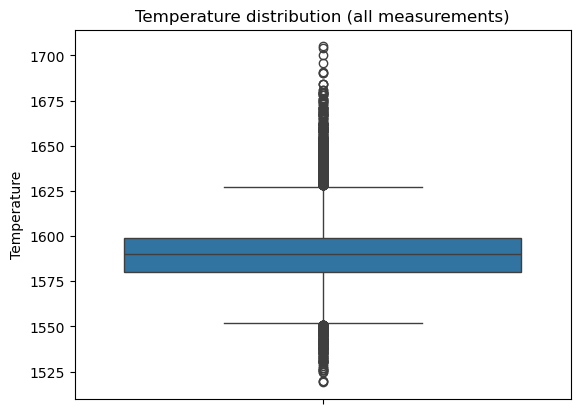

In [73]:
data_temp.drop(data_temp_low.index, inplace=True)
sns.boxplot(data=data_temp['Temperature'])
plt.title('Temperature distribution (all measurements)')
plt.ylabel('Temperature')
plt.show()

In [74]:
data_temp.shape

(13905, 3)

In [75]:
data_temp = data_temp.loc[data_temp['key'].map(data_temp['key'].value_counts()) > 1]
data_temp.shape

(13903, 3)

### Feature creation

Let's join the necessary features by keys.

In [76]:
data_arc['Heating time'] = (data_arc['End of arc heating'] - data_arc['Start of arc heating']
                            ).dt.total_seconds()
data_arc['Total power'] = (data_arc['Active power']**2 + data_arc['Reactive power']**2)**0.5
data_arc['Work'] = data_arc['Total power'] * data_arc['Heating time']
data_arc.head()

,key,Start of arc heating,End of arc heating,Active power,Reactive power,Heating time,Total power,Work
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253,228.0,0.371123,84.616003
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438,185.0,0.902319,166.928978
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460,172.0,0.722536,124.276277
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979,365.0,0.642824,234.630603
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691,148.0,1.079934,159.830252


Let's take the total work and total treatment time (including heating and breaks) for each batch.

In [77]:
data_arc_features = pd.pivot_table(data_arc, values='Work', index='key', aggfunc='sum').join(
    pd.DataFrame((pd.pivot_table(
        data_arc, values='End of arc heating', index='key', aggfunc='max')['End of arc heating'] - 
                  pd.pivot_table(
        data_arc, values='Start of arc heating', index='key', aggfunc='min')['Start of arc heating']
                 ).dt.total_seconds(), columns=['Treatment time']), on='key', how='inner')
data_arc_features.head()

,Work,Treatment time
key,,
1,770.282114,1583.0
2,481.760005,1144.0
3,722.837668,1525.0
4,683.455597,1093.0
5,512.169934,1362.0


In [78]:
data_arc_features.shape

(3213, 2)

Let's also take the data for bulk materials 3, 4, 6, 12, 14 and 15.

In [79]:
data_bulk_features = data_bulk.loc[
    :, ['key', 'Bulk 3', 'Bulk 4', 'Bulk 6', 'Bulk 12', 'Bulk 14', 'Bulk 15']].set_index('key')
data_bulk_features.head()

,Bulk 3,Bulk 4,Bulk 6,Bulk 12,Bulk 14,Bulk 15
key,,,,,,
1,0.0,43.0,0.0,206.0,150.0,154.0
2,0.0,73.0,0.0,206.0,149.0,154.0
3,0.0,34.0,0.0,205.0,152.0,153.0
4,0.0,81.0,0.0,207.0,153.0,154.0
5,0.0,78.0,0.0,203.0,151.0,152.0


In [80]:
data_bulk_features.shape

(3129, 6)

And data on wire materials 1 and 2.

In [81]:
data_wire_features = data_wire.loc[:, ['key', 'Wire 1', 'Wire 2']].set_index('key')
data_wire_features.head()

,Wire 1,Wire 2
key,,
1,60.059998,0.00000
2,96.052315,0.00000
3,91.160157,0.00000
4,89.063515,0.00000
5,89.238236,9.11456


In [82]:
data_wire_features.shape

(3081, 2)

We also use gas purge numbers.

In [83]:
data_gas_features = data_gas.set_index('key')
data_gas_features.head()

,Gas 1
key,
1,29.749986
2,12.555561
3,28.554793
4,18.841219
5,5.413692


In [84]:
data_gas_features.shape

(3239, 1)

In [85]:
data_temp_features = (
    data_temp.loc[data_temp.groupby('key')['Time of measurement'].idxmin(), ['key', 'Temperature']]\
    .set_index('key').rename(columns={'Temperature': 'Starting temperature'}).join(
    data_temp.loc[data_temp.groupby('key')['Time of measurement'].idxmax(), ['key', 'Temperature']]\
    .set_index('key').rename(columns={'Temperature': 'Final temperature'}), how='inner'))
data_temp_features.head()

,Starting temperature,Final temperature
key,,
1,1571.0,1613.0
2,1581.0,1602.0
3,1596.0,1599.0
4,1601.0,1625.0
5,1576.0,1602.0


In [86]:
data_temp_features.shape

(2471, 2)

Now joining them by key identifier.

In [87]:
features = data_arc_features.join(
    [data_bulk_features, data_wire_features, data_gas_features, data_temp_features], how='inner')
features.head()

,Work,Treatment time,Bulk 3,Bulk 4,Bulk 6,Bulk 12,Bulk 14,Bulk 15,Wire 1,Wire 2,Gas 1,Starting temperature,Final temperature
key,,,,,,,,,,,,,
1,770.282114,1583.0,0.0,43.0,0.0,206.0,150.0,154.0,60.059998,0.00000,29.749986,1571.0,1613.0
2,481.760005,1144.0,0.0,73.0,0.0,206.0,149.0,154.0,96.052315,0.00000,12.555561,1581.0,1602.0
3,722.837668,1525.0,0.0,34.0,0.0,205.0,152.0,153.0,91.160157,0.00000,28.554793,1596.0,1599.0
4,683.455597,1093.0,0.0,81.0,0.0,207.0,153.0,154.0,89.063515,0.00000,18.841219,1601.0,1625.0
5,512.169934,1362.0,0.0,78.0,0.0,203.0,151.0,152.0,89.238236,9.11456,5.413692,1576.0,1602.0


In [88]:
features.head()

,Work,Treatment time,Bulk 3,Bulk 4,Bulk 6,Bulk 12,Bulk 14,Bulk 15,Wire 1,Wire 2,Gas 1,Starting temperature,Final temperature
key,,,,,,,,,,,,,
1,770.282114,1583.0,0.0,43.0,0.0,206.0,150.0,154.0,60.059998,0.00000,29.749986,1571.0,1613.0
2,481.760005,1144.0,0.0,73.0,0.0,206.0,149.0,154.0,96.052315,0.00000,12.555561,1581.0,1602.0
3,722.837668,1525.0,0.0,34.0,0.0,205.0,152.0,153.0,91.160157,0.00000,28.554793,1596.0,1599.0
4,683.455597,1093.0,0.0,81.0,0.0,207.0,153.0,154.0,89.063515,0.00000,18.841219,1601.0,1625.0
5,512.169934,1362.0,0.0,78.0,0.0,203.0,151.0,152.0,89.238236,9.11456,5.413692,1576.0,1602.0


Let's separate the target feature.

In [89]:
target = pd.DataFrame(features['Final temperature'])
features.drop('Final temperature', axis=1, inplace=True)
print(features.shape)
print(target.shape)

(2324, 12)
(2324, 1)


In [90]:
target.head()

,Final temperature
key,
1,1613.0
2,1602.0
3,1599.0
4,1625.0
5,1602.0


## Feature study

In [91]:
# a function to define custom boundaries of the box plot whiskers
def IQR_borders(series, coef=1.5, skip_zero=False):
    if skip_zero:
        series = series.replace({0.0: np.nan})
    
    IQR = series.quantile(0.75) - series.quantile(0.25)
    low_border = series.quantile(0.25) - coef * IQR
    top_border = series.quantile(0.75) + coef * IQR
    
    if low_border < series.min():
        low_border = series.min()
    if top_border > series.max():
        top_border = series.max()
    
    return low_border, top_border

In [92]:
features.head()

,Work,Treatment time,Bulk 3,Bulk 4,Bulk 6,Bulk 12,Bulk 14,Bulk 15,Wire 1,Wire 2,Gas 1,Starting temperature
key,,,,,,,,,,,,
1,770.282114,1583.0,0.0,43.0,0.0,206.0,150.0,154.0,60.059998,0.00000,29.749986,1571.0
2,481.760005,1144.0,0.0,73.0,0.0,206.0,149.0,154.0,96.052315,0.00000,12.555561,1581.0
3,722.837668,1525.0,0.0,34.0,0.0,205.0,152.0,153.0,91.160157,0.00000,28.554793,1596.0
4,683.455597,1093.0,0.0,81.0,0.0,207.0,153.0,154.0,89.063515,0.00000,18.841219,1601.0
5,512.169934,1362.0,0.0,78.0,0.0,203.0,151.0,152.0,89.238236,9.11456,5.413692,1576.0


### Work

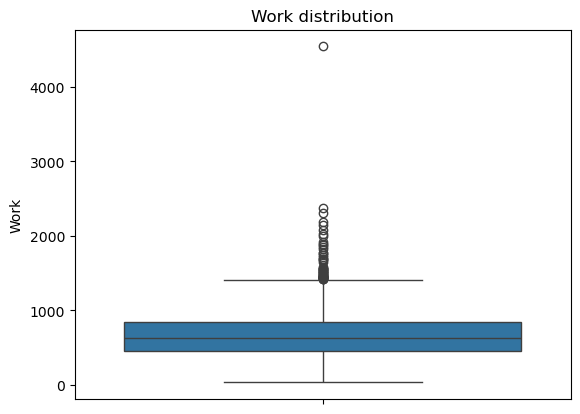

In [93]:
sns.boxplot(y=features['Work'])
plt.title('Work distribution')
plt.show()

In [94]:
IQR_borders(features['Work'])

(33.43020759374457, 1417.673049777378)

In [95]:
features.sort_values(by='Work').head()

,Work,Treatment time,Bulk 3,Bulk 4,Bulk 6,Bulk 12,Bulk 14,Bulk 15,Wire 1,Wire 2,Gas 1,Starting temperature
key,,,,,,,,,,,,
943,33.430208,61.0,0.0,124.0,0.0,0.0,0.0,0.0,168.105591,0.000000,4.144089,1609.0
977,35.525857,57.0,70.0,0.0,0.0,0.0,0.0,0.0,65.098801,90.087921,3.143110,1604.0
2112,41.487172,125.0,0.0,0.0,25.0,0.0,0.0,0.0,33.065762,0.000000,5.302748,1588.0
1773,50.454545,224.0,19.0,0.0,0.0,0.0,0.0,0.0,89.153992,40.082642,5.208462,1609.0
1281,56.453138,132.0,68.0,0.0,0.0,0.0,0.0,0.0,130.057190,0.000000,9.467235,1621.0


I don't think the low work values are anomalies. The steel was already at a fairly high temperature when the measurements started.

The outliers at this upper bound will be cut off in the training sample.

### Treatment time

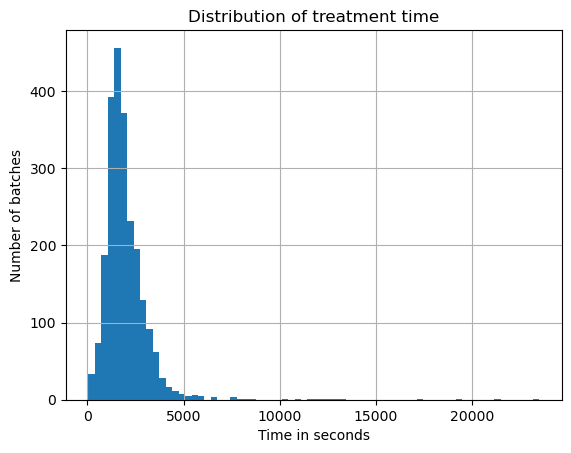

In [96]:
features['Treatment time'].hist(bins=70)
plt.title('Distribution of treatment time')
plt.ylabel('Number of batches')
plt.xlabel('Time in seconds')
plt.show()

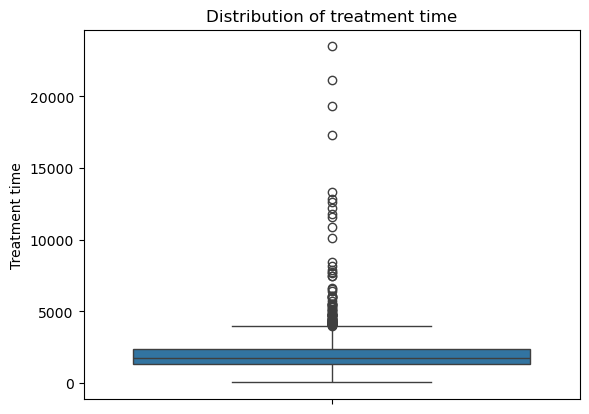

In [97]:
sns.boxplot(y=features['Treatment time'])
plt.title('Distribution of treatment time')
plt.show()

There's even more outliers here. Probably due to the long breaks.

### Starting temperature

In [98]:
features['Starting temperature']

key
1       1571.0
2       1581.0
3       1596.0
4       1601.0
5       1576.0
         ...  
2495    1570.0
2496    1554.0
2497    1571.0
2498    1591.0
2499    1569.0
Name: Starting temperature, Length: 2324, dtype: float64

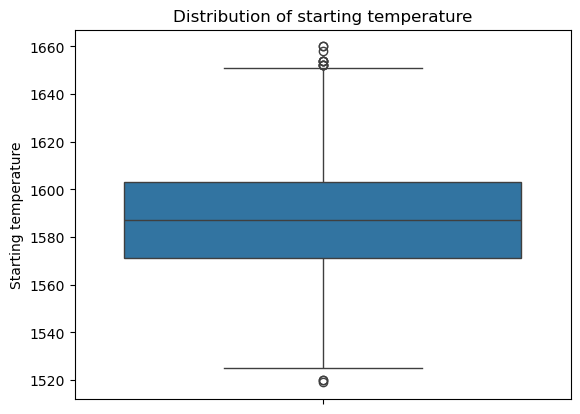

In [99]:
sns.boxplot(y=features['Starting temperature'])
plt.title('Distribution of starting temperature')
plt.show()

These data are more clumped. Outliers do not actually look like ones, because they exceed the whiskers only slightly. We will not exclude them from the training sample.

### Correlation

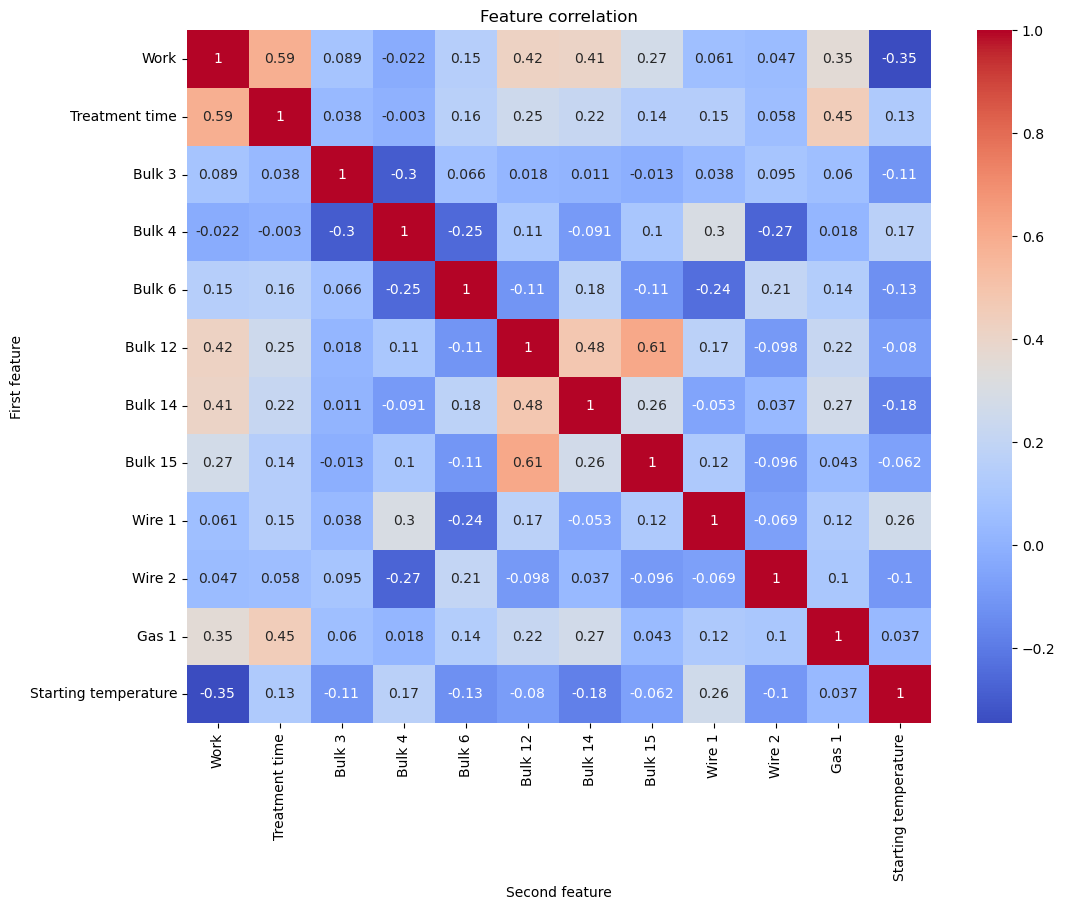

In [100]:
fig, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(features.corr(), annot=True, cmap='coolwarm')
plt.title('Feature correlation')
plt.ylabel('First feature')
plt.xlabel('Second feature')
plt.show()

Both positive and negative correlations are within acceptable limits. We're not going to remove anything.

## Samples

Let's split the data into training and test datasets.

In [101]:
features_train, features_test, target_train, target_test = train_test_split(
    features, target, random_state=140823)

In [102]:
print(features_train.shape)
print(features_test.shape)
print(target_train.shape)
print(target_test.shape)

(1743, 12)
(581, 12)
(1743, 1)
(581, 1)


## Outliers

Let's remove outliers from the training sample.

In [103]:
features_train = features_train.loc[features_train[
    ['Work', 'Treatment time', 'Bulk 3', 'Bulk 4', 'Bulk 6', 
     'Bulk 12', 'Bulk 14', 'Bulk 15', 'Wire 1', 'Wire 2', 'Gas 1']
].apply(lambda x: x < IQR_borders(x, coef=2.5, skip_zero=True)[1]).all(1)]

In [104]:
features_train.shape

(1672, 12)

In [105]:
features_train.describe()

,Work,Treatment time,Bulk 3,Bulk 4,Bulk 6,Bulk 12,Bulk 14,Bulk 15,Wire 1,Wire 2,Gas 1,Starting temperature
count,1672.000000,1672.000000,1672.000000,1672.000000,1672.000000,1672.000000,1672.000000,1672.000000,1672.000000,1672.000000,1672.000000,1672.000000
mean,647.065630,1857.608254,45.992225,37.212919,21.754187,205.908493,152.068182,119.890550,101.917658,16.339297,10.852831,1587.251794
std,280.889583,805.990964,72.257763,58.947208,53.855548,149.545441,78.055544,83.726468,42.620899,30.622180,5.193093,23.105993
min,35.525857,57.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.008399,1520.000000
25%,444.731981,1314.750000,0.000000,0.000000,0.000000,105.000000,105.000000,0.000000,72.159360,0.000000,7.312645,1571.000000
50%,615.805998,1712.000000,0.000000,0.000000,0.000000,206.000000,148.000000,107.000000,101.041198,0.000000,9.947561,1586.500000
75%,818.691952,2320.750000,77.000000,78.000000,0.000000,271.250000,203.000000,204.000000,127.155593,21.089379,13.817779,1602.000000
max,1775.756671,4918.000000,372.000000,276.000000,359.000000,685.000000,417.000000,258.000000,242.143203,180.236161,30.647331,1660.000000


In [106]:
target_train = target_train.loc[features_train.index]
target_train.shape

(1672, 1)

## Scaling

In [107]:
features_train.head()

,Work,Treatment time,Bulk 3,Bulk 4,Bulk 6,Bulk 12,Bulk 14,Bulk 15,Wire 1,Wire 2,Gas 1,Starting temperature
key,,,,,,,,,,,,
795,1293.299356,2186.0,92.0,0.0,0.0,377.0,213.0,176.0,65.098801,10.163919,8.998206,1567.0
1438,1036.605968,3108.0,294.0,0.0,0.0,186.0,130.0,126.0,207.323990,11.129040,3.564328,1589.0
1275,571.302842,2009.0,0.0,113.0,0.0,230.0,103.0,103.0,111.103203,0.000000,9.616335,1582.0
2260,1712.716410,3372.0,0.0,80.0,0.0,314.0,197.0,207.0,106.142402,30.129841,13.817066,1575.0
1161,172.230187,1220.0,167.0,0.0,0.0,0.0,0.0,0.0,110.073601,0.000000,5.306884,1600.0


Now the scaling itself.

In [108]:
scaler = StandardScaler()
scaler.fit(features_train)

features_train = pd.DataFrame(scaler.transform(features_train), 
                              index=features_train.index, 
                              columns=features_train.columns)
features_test = pd.DataFrame(scaler.transform(features_test), 
                             index=features_test.index, 
                             columns=features_test.columns)

In [109]:
features_train.head()

,Work,Treatment time,Bulk 3,Bulk 4,Bulk 6,Bulk 12,Bulk 14,Bulk 15,Wire 1,Wire 2,Gas 1,Starting temperature
key,,,,,,,,,,,,
795,2.301356,0.407560,0.636908,-0.631481,-0.404057,1.144419,0.780855,0.670352,-0.864127,-0.201724,-0.357240,-0.876736
1438,1.387224,1.551836,3.433292,-0.631481,-0.404057,-0.133167,-0.282809,0.072991,2.473854,-0.170197,-1.403919,0.075683
1275,-0.269805,0.187889,-0.636693,1.286062,-0.404057,0.161146,-0.628820,-0.201795,0.215582,-0.533737,-0.238175,-0.227359
2260,3.794977,1.879481,-0.636693,0.726071,-0.404057,0.723017,0.575811,1.040716,0.099153,0.450480,0.570974,-0.530402
1161,-1.690976,-0.791323,1.675169,-0.631481,-0.404057,-1.377308,-1.948788,-1.432360,0.191417,-0.533737,-1.068266,0.551892


## Training

In [110]:
STATE = np.random.RandomState(140823)
CV = 5

### Linear regression

In [111]:
model_linear_regression = LinearRegression()
scores = cross_val_score(model_linear_regression, 
                         features_train, 
                         target_train, 
                         scoring='neg_mean_absolute_error', cv=CV)
scores.mean()

-6.408858098099143

### Elastic Net

In [112]:
warnings.filterwarnings("ignore", category=ConvergenceWarning)

In [113]:
warnings.filterwarnings("ignore", category=UserWarning)
model_elastic_net = ElasticNet(random_state=STATE)

param_dict = {'alpha': [0.01, 0.1, 0, 1, 10, 100], 
              'l1_ratio': [0, 0.3, 0.5, 0.7, 1.0]}
gsearch_elastic_net = GridSearchCV(model_elastic_net, param_grid=param_dict, 
                                   scoring='neg_mean_absolute_error', 
                                   cv=CV)
gsearch_elastic_net.fit(features_train, target_train)

print(gsearch_elastic_net.best_params_)
print(gsearch_elastic_net.best_score_)

{'alpha': 0.1, 'l1_ratio': 0.7}
-6.390966537103227


### Random Forest

In [114]:
%%time
model_random_forest = RandomForestRegressor(random_state=STATE)

param_dict = {'max_depth': range(1, 30, 4), 
              'n_estimators': range(100, 501, 100)}
rsearch_random_forest = RandomizedSearchCV(model_random_forest, param_distributions=param_dict, 
                                           scoring='neg_mean_absolute_error', 
                                           random_state=STATE, cv=CV, 
                                           n_iter=10, verbose=False)
rsearch_random_forest.fit(features_train, target_train.values.ravel())

print(rsearch_random_forest.best_params_)
print(rsearch_random_forest.best_score_)

{'n_estimators': 400, 'max_depth': 13}
-6.15745990761569
CPU times: user 1min 58s, sys: 658 ms, total: 1min 59s
Wall time: 1min 59s


### CatBoost

In [115]:
%%time
model_cat_boost = CatBoostRegressor(loss_function='MAE', logging_level='Silent')

param_dict = {'iterations': [100, 300, 500, 700, 1000, 1500], 
              'learning_rate': [0.005, 0.01, 0.03, 0.05, 0.1], 
              'depth': [1, 3, 5, 7, 10], 
              'l2_leaf_reg': [0.2, 0.5, 1, 1.5, 3]}
rsearch_cat_boost = RandomizedSearchCV(model_cat_boost, param_distributions=param_dict, 
                                       scoring='neg_mean_absolute_error', 
                                       random_state=STATE, cv=CV, 
                                       n_iter=20)
rsearch_cat_boost.fit(features_train, target_train.values.ravel())

print(rsearch_cat_boost.best_params_)
print(rsearch_cat_boost.best_score_)

{'learning_rate': 0.01, 'l2_leaf_reg': 1.5, 'iterations': 1500, 'depth': 5}
-6.074440345063373
CPU times: user 51min 57s, sys: 5min 22s, total: 57min 19s
Wall time: 9min 2s


### LightGBM

In [116]:
%%time
model_light_gbm = lgb.LGBMRegressor(objective='regression', random_state=STATE)

param_dict = {'learning_rate': [0.05, 0.1, 0.2], 
               'n_estimators': [50, 100, 150, 200], 
               'colsample_bytree': [0.5, 0.7, 1.0]}
rsearch_light_gbm = RandomizedSearchCV(model_light_gbm, param_distributions=param_dict, 
                                       scoring='neg_mean_absolute_error', 
                                       random_state=STATE, cv=CV, 
                                       n_iter=10, verbose=False)

rsearch_light_gbm.fit(features_train, target_train)
print(rsearch_light_gbm.best_params_)
print(rsearch_light_gbm.best_score_)

{'n_estimators': 150, 'learning_rate': 0.05, 'colsample_bytree': 0.5}
-6.226735418695158
CPU times: user 1min 23s, sys: 1.5 s, total: 1min 25s
Wall time: 10.7 s


## Results

<a id='results'></a>
|Model|Linear Regression|Elastic Net|Random Forest|CatBoost|LightGBM|
|-|-|-|-|-|-|
|MAE|6.41|6.39|6.16|6.07|6.23|
|Hyperparameter 1||'alpha': 0.1|'n_estimators': 400|'learning_rate': 0.01|'n_estimators': 150|
|Hyperparameter 2||'l1_ratio': 0.7|'max_depth': 13|'l2_leaf_reg': 1.5|'learning_rate': 0.05|
|Hyperparameter 3||||'iterations': 1500|'colsample_bytree': 0.5|
|Hyperparameter 4||||'depth': 5||

## Sanity check

The best result was shown by CatBoost. Let's compare it with the model that always predicts the mean or median.

In [117]:
model_dummy_mean = DummyRegressor(strategy='mean')
cross_val_score(model_dummy_mean, features_train, target_train, 
                scoring='neg_mean_absolute_error').mean()

-7.629712599318441

In [118]:
model_dummy_median = DummyRegressor(strategy='median')
cross_val_score(model_dummy_median, features_train, target_train, 
                scoring='neg_mean_absolute_error').mean()

-7.6076056841540804

It's not that big of a difference. Still, CatBoost is better.

In [119]:
model_dummy_mean = DummyRegressor(strategy='mean')
model_dummy_mean.fit(features_train, target_train)
predictions_test = model_dummy_mean.predict(features_test)
mae(target_test, predictions_test)

8.676413789127809

In [120]:
model_dummy_median = DummyRegressor(strategy='median')
model_dummy_median.fit(features_train, target_train)
predictions_test = model_dummy_median.predict(features_test)
mae(target_test, predictions_test)

8.6592082616179

## Analysis of the feature significance

In [121]:
feature_importance = pd.DataFrame(rsearch_cat_boost.best_estimator_.get_feature_importance(), 
                                  index=features_train.columns, columns=['Significance'])
feature_importance.sort_values(by='Significance', ascending=False, inplace=True)
feature_importance

,Significance
Starting temperature,21.994527
Work,20.674584
Wire 1,8.671624
Bulk 6,7.593738
Wire 2,7.076232
Treatment time,6.457542
Gas 1,6.186736
Bulk 12,5.707024
Bulk 14,5.443537
Bulk 15,5.077020


<a id='importance'></a>

/tmp/ipykernel_16256/4099338863.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color=plt.cm.get_cmap('Set1').colors)


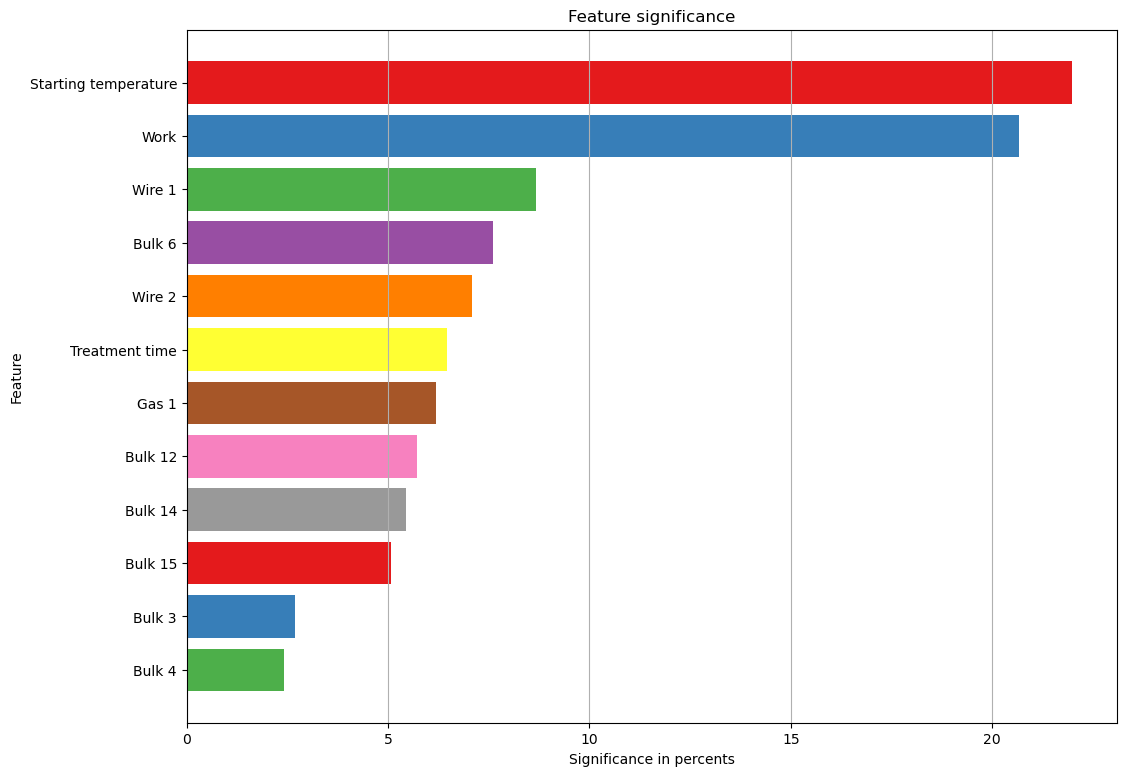

In [122]:
fig, ax = plt.subplots(figsize=(12, 9))
plt.barh(y=feature_importance.index, 
         width=feature_importance['Significance'], 
         color=plt.cm.get_cmap('Set1').colors)
ax.invert_yaxis()
ax.grid(axis='x')
plt.title('Feature significance')
plt.xlabel('Significance in percents')
plt.ylabel('Feature')
plt.show()

Heating work and starting temperature are noticeably in the lead.

## Testing

We train CatBoostRegressor with the selected hyperparameters on the whole training sample.

In [123]:
model = CatBoostRegressor(loss_function='MAE', logging_level='Silent', 
                          depth=5, iterations=1500, learning_rate=0.01, l2_leaf_reg=1.5)
model.fit(features_train, target_train)
predictions_test = model.predict(features_test)

print(mae(target_test, predictions_test))

6.785062392433639


Technically, this model is already trained in the hyperparameter fitting process.

In [124]:
predictions_test = rsearch_cat_boost.best_estimator_.predict(features_test)

print(mae(target_test, predictions_test))

6.785062392433639


## Conclusions

1. The following data were used for training:
    - Work calculated from both powers and heating time
    - Total treatment time for each batch
    - Volume of added bulk materials 3, 4, 6, 12, 14, 15
    - Volume of added wire materials 1 and 2
    - Data on the Gas 1 alloy purging
    - Starting temperature
2. Several anomalies have been found in the data: negative reactive power and an implausibly low temperature of about 1200 degrees Celsius.
3. Training was performed on data without outliers (values beyond the 3rd quartile + 2.5 interquartile range), testing was performed on data with outliers.
4. The tried-and-tested models at cross-validation showed rather close values of MAE in the interval from 6.07 to 6.41. CatBoost showed the best one.
5. At testing CatBoostRegressor with selected hyperparameters showed MAE = 6.79
6. The default model, predicting always the mean value, showed MAE = 8.68.
7. From the feature importance analysis, it is observed that starting temperature and heating work are the determining features. Wire materials also contribute a lot to the prediction result. The role of bulk materials varies.

## Report

1. Comparison of the plan and work by steps
    1. Data loading was performed without troubles.
    2. The processing of missing values was also carried out accordingly.
    3. An unplanned check was made for **duplicates**. **None of them** were found.
    4. The defined anomalies were removed.
    5. Features such as batch total heating work and total treatment time were created according to the formula below.
    6. In addition to these, all of the planned attributes for bulk and wire materials data, gas purging data, as well as the data on starting and final temperatures of the alloy were taken.
    7. These 13 attributes were aggregated by batch ID. Only batches for which information on all these attributes was available (after dealing with gaps) were used for training and testing.
    8. The final (i.e. last measured) temperature was separated as the target feature.
    9. An exploratory data analysis was performed for the 12 features used in training. Since it was necessary to identify outliers (for further exclusion from the training sample), an off-scheduled **function** was written  **to define the boundaries** beyond which numbers were considered outliers.
    10. Correlation between features was also studied in a separate section. To get an illustrative picture, a heat map was constructed. The highest correlation was between bulk materials 12 and 15 (0.61).
    11. The resulting data were divided into training and test sample in the ratio of 3:1. The `random_state=140823` was used in the splitting.
    12. Using the function written earlier, batches with outliers were removed from the training sample. This was done for all features except starting temperature (precisely, 11 out of 12). The variation from the plan is that **batches with the outliers in the numbers of total work and batch treatment time were also removed**. This was not in the plan because the distributions of these features were not constructed in the primary data analysis.
    13. Next, the data scaling was performed.
    14. All 5 models have been successfully trained:
        - Linear Regression
        - Elastic Net
        - Random Forest
        - LightGBM
        - CatBoost
    15. Once the best model (CatBoost) was selected, a comparison was made with constant models that always predicted mean and median. This was done for both the training sample (on cross-validation), and the test sample based on the training sample. In both cases, CatBoostRegressor showed higher accuracy (e.g., 6.79 to 8.66).
    16. Further according to the plan was the analysis of feature importance. The greatest contribution was made by total work and starting temperature.
    17. Finally, the model with optimal hyperparameters was tested.
2. Project difficulties
    1. There were found a lot of missing values in the temperature data. Specifically, there was no temperature data for 739 batches. This significantly reduced the amount of data for training. About 150 rows were also lost when merging features by batch ID. Unfortunately, filling the gaps with medians only deteriorated the metric, so the work was done only with 2324 objects.
    2. The model overtrained on data without outliers. To improve the situation and increase the metric in testing, batches with numbers up to the 3rd quartile plus 2.5 interquartile ranges had to be added.
3. Key solution steps
    1. The creation of a feature such as total heating work has made a significant contribution. The first temperature measurement is also very important. Perhaps artificial creation of more features could also improve accuracy.
    2. Data scaling should also have had a significant impact. Otherwise, the model could "decide" that a feature such as total treatment time was more important than others. Although the analysis of feature importance showed the opposite.
    3. Removing outliers turned out to result in a low metric. Adding them, accordingly, improved the MAE.
4. Features and their preprocessing
    1. **Total work** for each batch was calculated as
    $\sum_{i=1}^{n} \text{Heating time}_i \cdot \sqrt{\text{Active power}_i^2 + \text{Reactive power}_i^2}$  
    , where i is the arc heating serial number and n is the number of arc heatings for the batch.
    2. **Total treatment time** for each batch was calculated as
    $\text{End of heating arc}_n -  \text{Start of heating arc}_1$  
    , where n is the number of arc heatings for the batch.
    3. The volumes of added bulk materials 3, 4, 6, 12, 14 and 15 and the volumes of added wire materials 1 and 2 were used. Gaps in these data were filled with zeros.
    4. Batches with gaps in temperature values were removed from the temperature data. The batches with one temperature measurement were also removed. Among the remaining data for each batch, the first temperature measurement was taken as the starting temperature (so, a feature for training), whereas the last one was taken as the final temperature (the target metric).
    5. The batch with negative reactive power and the batches with alloy temperature around 1200 degrees Celsius were also removed before calculating and processing the features. They were taken as anomalies.
    6. The numbers characterizing gas purging did not need preprocessing.
5. Full model description
    1. The CatBoostRegressor model with the following hyperparameters showed the best MAE:
        - 'learning_rate': 0.01
        - 'l2_leaf_reg': 1.5
        - 'iterations': 1500
        - 'depth': 5
    2. The parameter selection was done with 20 iterations of `RandomizedSearchCV`. There may be a more optimal combination.
6. Final metric
    1. CatBoostRegressor showed MAE = 6.79 in testing
    2. In comparison, the constant model predicting the median of the training sample showed MAE = 8.66
7. Recommendations for improving the solution
    1. It makes sense to create more features. The feature importance analysis showed that total work plays an important role. There could be quantities that reveal this relationship.
    2. Based on the test results, it can be assumed that adding outliers has a positive effect on model training. It is worth to check how the model will show itself when trained on all data.